## Model Training

> This notebook contains code for training the model on the entirety of the dataset comprising of Stanford Dogs and Tsinghua dogs.

In [1]:
#| default_exp model_training

In [2]:
#| export
from dog_breed_id.data_preprocessing import read_csv_with_array_columns
from dog_breed_id.research import get_classes_from_frame
from dog_breed_id.benchmark import *
from miniai.learner import *
from miniai.init import *
from miniai.activations import *
from miniai.sgd import *
from miniai.datasets import show_images

import cv2
import fastcore.all as fc
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import glob
import os
from matplotlib import pyplot as plt

import shutil
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torcheval.metrics import MulticlassAccuracy
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
import timm

/Users/dhritimansagar/Dev/dog_breed_id/venv31013/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Add a fixed seed to ensure reproducability of dataset splits and model training. Reference - https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964

In [3]:
#| export

import os 
import random
import numpy as np 

DEFAULT_RANDOM_SEED = 2021

def seed_basic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# torch random seed
import torch
def seed_torch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seed_everything(seed=DEFAULT_RANDOM_SEED):
    seed_basic(seed)
    seed_torch(seed)

In [4]:
seed_everything(DEFAULT_RANDOM_SEED)

In [5]:
df = read_csv_with_array_columns('../data/dogs.csv', ['bboxes'])

In [6]:
label2id, id2label = get_id_mappings(df, include_background=False)
weights = get_class_weights(df, label2id)

Get the training, validation and test subsets.

In [8]:
#| export
def get_subsets(df, valid_size=0.1, random_state=DEFAULT_RANDOM_SEED):
    train_subset, valid_subset = train_test_split(df, test_size=valid_size, stratify=df['category'], random_state=random_state)
    valid_subset, test_subset = train_test_split(valid_subset, train_size=0.5, test_size=0.5, random_state=random_state)
    return train_subset, valid_subset, test_subset

In [9]:
train_subset, valid_subset, test_subset = get_subsets(df)

Set up appropriate datasets and dataloaders.

In [14]:
train_ds = DogBreedClassificationDataset(train_subset, label2id, id2label, TRAIN_TRANSFORMS)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=48)

valid_ds = DogBreedClassificationDataset(valid_subset, label2id, id2label, VALID_TRANSFORMS)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=48)

test_ds = DogBreedClassificationDataset(test_subset, label2id, id2label, VALID_TRANSFORMS)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=48)

In [15]:
astats = ActivationStats(fc.risinstance(torch.nn.ReLU))
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

In [16]:
dls = DataLoaders(train_dl, valid_dl)

## Full Model Training

During my small benchmark, resnet50 overfit the small set of data I had experimented with. **Because my dataset is much larger, I hypothesize that training the full model (with all layers unfrozen) will do well**. I could also train full ConvNeXt but I do't have the resources to train that model (requires a much larger GPU).

In [18]:
from functools import partial
model = timm.create_model('resnet50', pretrained=True, num_classes=137)
init_model(model, initialize=False, freeze_backbone=False)
lr = 1e-3
epochs = 50
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learner = TrainLearner(model, dls=dls, loss_func=torch.nn.CrossEntropyLoss(), cbs=cbs+[RegularizerCB(alpha=5e-5)]+xtra, 
                       opt_func=torch.optim.Adam)

accuracy,loss,epoch,train
0.441,56.283,0,train
0.800,49.292,0,eval
0.789,44.726,1,train
0.840,40.090,1,eval
0.828,36.122,2,train
0.852,32.180,2,eval
0.853,28.795,3,train
0.853,25.574,3,eval
0.863,22.795,4,train
0.843,20.296,4,eval


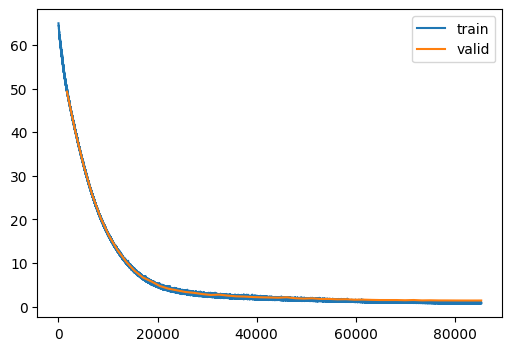

In [19]:
learner.fit(n_epochs=epochs)

In [20]:
torch.save(model.state_dict(), 'resnet50.pt')

## Test Set Performance 
So we notice that convnext has a better accuracy on validation set however resnet50 has better performance on the training set, supporting the assumption that resnet50 is overfitting on this small benchmark. Let's test the accuracy of both models on the test set.

In [21]:
resnet = timm.create_model('resnet50', pretrained=True, num_classes=137)
resnet.load_state_dict(torch.load('resnet50.pt'))

<All keys matched successfully>

In [22]:
print(f'ResNet50 test set accuracy: {get_classification_accuracy(resnet, test_dl):.2f}')

ResNet50 test set accuracy: 0.85


Overall, given there are 137 unique classes in the dataset, **this performance is really good.**

In [96]:
#| hide
import nbdev; nbdev.nbdev_export()